# Combining eco-evolutionary theory and machine learning to improve our understanding of living systems


<blockquote>

*Les données pertinentes détiennent les réponses.*

</blockquote>

French anagram

In this post, I discuss the benefits and drawbacks of using empirical (ML)-based models versus mechanistic models for predicting ecosystem responses to perturbations. I also explore how recent advances in inverse modelling techniques are blurring the boundary between ML-based and mechanistic approaches. Additionally, I discuss how hybrid models, which incorporate both ML-based and mechanistic components, allow benefitting from the best of both worlds. By examining the strengths and limitations of these different modelling approaches, I hope to provide insights into how best to use them to advance our knowledge of ecological and evolutionary dynamics.

In this blog post, we will explore the benefits and drawbacks of different modelling approaches for predicting ecological time series from a mechanistic model. We will begin by generating a set of time series data from a mechanistic model of an ecological system, which will serve as a baseline for comparison with empirical data. This will allow us to evaluate the performance of different modelling approaches under controlled conditions, without the confounding effects of real-world data.

Once we have generated our time series data, we will proceed to apply different modelling approaches to the data, including empirical (ML)-based models, mechanistic models, and hybrid models. We will evaluate the performance of these models in terms of their accuracy, precision, and generalizability, and discuss the strengths and limitations of each approach.

The ultimate goal of this exercise is to provide insights into how best to use different modelling approaches for predicting ecological time series, and to highlight the potential benefits and drawbacks of each approach. By examining the performance of different models under controlled conditions, we hope to provide a useful framework for evaluating the performance of these models in the real world.

## Synthetic ecosystem considered

- We consider a 3 species ecosystem model

$$
\begin{align}
    \text{basal growth of } \text{🌱} &= f(\text{💧})\\
    \text{🌱} &= \text{basal growth} - \text{competition} - \text{grazing} - \text{death}\\
    \text{🦓} &= \text{grazing} - \text{predation} - \text{death}\\
    \text{🦁} &= \text{predation} - \text{death}
\end{align}
$$

In [1]:
cd(@__DIR__)
import Pkg; Pkg.activate(".")
using PythonCall
nx = pyimport("networkx")
np = pyimport("numpy")
include("model.jl")
include("utils.jl");


  Activating project at `~/ETHZ/PostDoc_ELE/conf/RU_meeting_March_2023`
    CondaPkg Found dependencies: /Users/victorboussange/ETHZ/PostDoc_ELE/conf/RU_meeting_March_2023/CondaPkg.toml
    CondaPkg Found dependencies: /Users/victorboussange/.julia/packages/PythonCall/dsECZ/CondaPkg.toml
    CondaPkg Found dependencies: /Users/victorboussange/.julia/packages/PythonPlot/f591M/CondaPkg.toml
    CondaPkg Found dependencies: /Users/victorboussange/.julia/environments/v1.8/CondaPkg.toml
    CondaPkg Found dependencies: /Users/victorboussange/.julia/packages/PythonCall/ZzOaq/CondaPkg.toml
    CondaPkg Dependencies already up to date
[ Info: Precompiling ParametricModels [ea05b012-1b06-4aec-a786-2a545e229cd0]
[ Info: Skipping precompilation since __precompile__(false). Importing ParametricModels [ea05b012-1b06-4aec-a786-2a545e229cd0].
[ Info: Precompiling EcoEvoModelZoo [96372a6d-8f12-4b28-95ba-ac697ae6fb10]
┌ Warning: Module ParametricModels with build ID 275760955338417 is missing from the 

In [2]:
using EcoEvoModelZoo

N = 3 # number of species

pos = Dict(1 => [0, 0], 2 => [0.2, 1], 3 => [0, 2])
labs = Dict(1 => "Resource", 2 => "Consumer", 3 => "Prey")

foodweb = DiGraph(N)
add_edge!(foodweb, 2 => 1) # Consumer (node 2) feeds on Resource (node 1)
add_edge!(foodweb, 3 => 2) # Predator (node 3) fonds on consumer (node 2)
println(foodweb)



SimpleDiGraph{Int64}(2, [Int64[], [1], [2]], [[2], [3], Int64[]])


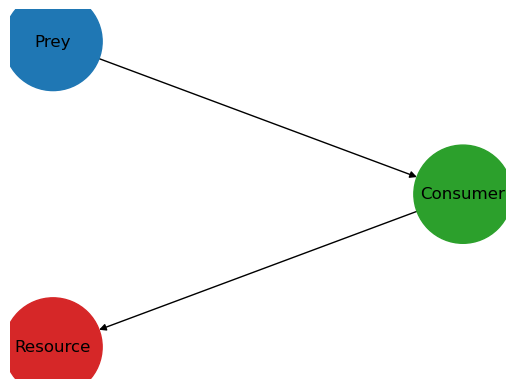

(<py Figure size 640x480 with 1 Axes>, <py Axes: >)

In [3]:
plot_foodweb(foodweb, pos, labs)

In [4]:
function carrying_capacity(p, t)
    @unpack K₁₁ = p
    K = vcat(K₁₁, ones(Float32, N - 1))
    return K
end

carrying_capacity (generic function with 1 method)

In [5]:
function competition(u, p, t)
    @unpack A₁₁ = p
    A = spdiagm(vcat(A₁₁, zeros(Float32, 2)))
    return A * u
end

competition (generic function with 1 method)

In [6]:
resource_conversion_efficiency(p, t) = ones(Float32, N)

resource_conversion_efficiency (generic function with 1 method)

In [7]:
W = adjacency_matrix(foodweb)
I, J, _ = findnz(W)

function feeding(u, p, t)
    @unpack H₂₁, H₃₂, q₂₁, q₃₂ = p

    # handling time
    H = sparse(I, J, vcat(H₂₁, H₃₂), N, N)

    # attack rates
    q = sparse(I, J, vcat(q₂₁, q₃₂), N, N)

    return q .* W ./ (one(eltype(u)) .+ q .* H .* (W * u))
end

feeding (generic function with 1 method)

### Functional responses

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/FunctionalResponsesGraph.svg/1024px-FunctionalResponsesGraph.svg.png)

In ecological modeling, the function response describes the relationship between a predator's consumption rate and its prey density. The function response is typically modeled as a curve that shows how the predator's consumption rate changes as prey density increases.

Two important parameters in the function response are the handling time and the attack rate. The handling time is the time it takes for a predator to handle and consume a single prey item. The attack rate is the rate at which a predator encounters and attacks prey items.

In mathematical terms, the function response can be modeled using the Holling Type II or III functional response equations, which take the form:

Type II:
dC/dt = a * N / (1 + h * a * N)

Type III:
dC/dt = a * N^p / (1 + h * a * N^p)

where C is the predator's consumption rate, N is the prey density, a is the attack rate, h is the handling time, and p is a shape parameter.

The handling time affects the shape of the function response curve by determining the maximum consumption rate that a predator can achieve. A longer handling time means that the predator will not be able to consume as many prey items in a given amount of time, which results in a lower maximum consumption rate.

The attack rate affects the slope of the function response curve by determining how quickly the predator's consumption rate increases with increasing prey density. A higher attack rate means that the predator will be able to consume more prey items per unit time, which results in a steeper function response curve.

In summary, the handling time and attack rate are important parameters in the function response equation, which describe the relationship between a predator's consumption rate and its prey density. The handling time affects the maximum consumption rate that a predator can achieve, while the attack rate affects how quickly the predator's consumption rate increases with increasing prey density.

In [8]:
water_availability(t) = sin.(2 * pi / 600 * 5 * t)

growth_rate_resource(r, water) = r * exp(-0.5*(water)^2)

intinsic_growth_rate(p, t) = [growth_rate_resource(p.r[1], water_availability(t)); p.r[2:end]]


intinsic_growth_rate (generic function with 1 method)

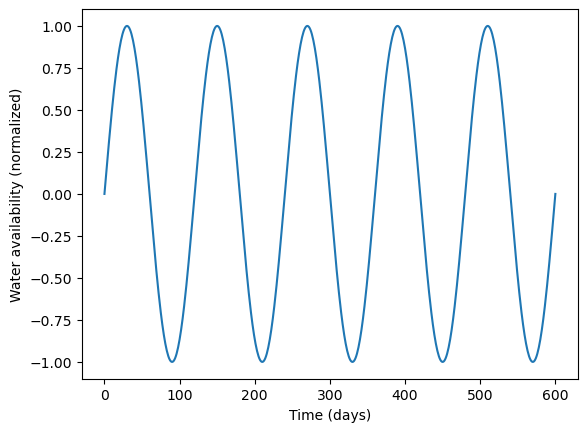

Python None

In [9]:
ts = tspan[1]:1:tspan[end]
fig = figure()
plot(ts, water_availability.(ts))
xlabel("Time (days)")
ylabel("Water availability (normalized)")
fig.set_facecolor("None")


In [10]:
p_true = ComponentArray(H₂₁=Float32[1.24],
                        H₃₂=Float32[2.5],
                        q₂₁=Float32[4.98],
                        q₃₂=Float32[0.8],
                        r=Float32[1.0, -0.4, -0.08],
                        K₁₁=Float32[1.0],
                        A₁₁=Float32[1.0])


ComponentVector{Float32}(H₂₁ = Float32[1.24], H₃₂ = Float32[2.5], q₂₁ = Float32[4.98], q₃₂ = Float32[0.8], r = Float32[1.0, -0.4, -0.08], K₁₁ = Float32[1.0], A₁₁ = Float32[1.0])

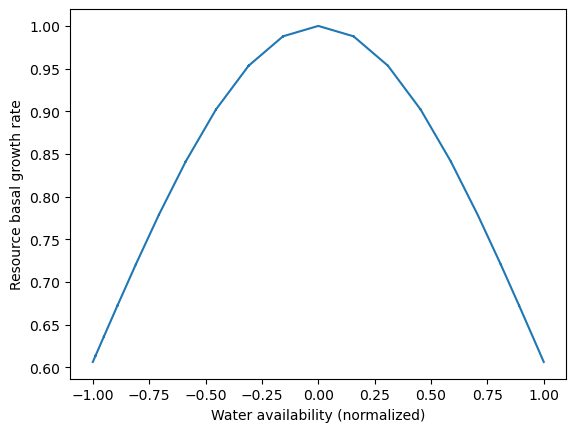

Python None

In [11]:
water_avail_range = reshape(sort!(water_availability.(tsteps)),length(tsteps))

fig = figure()
plot(water_avail_range, growth_rate_resource.(p_true.r[1], water_avail_range))
xlabel("Water availability (normalized)")
ylabel("Resource basal growth rate")
fig.set_facecolor("none")

In [12]:
u0_true = Float32[0.77, 0.060, 0.945]

mp = ModelParams(;p=p_true,
                tspan,
                u0=u0_true,
                solve_params...)

model = SimpleEcosystemModel(; 
                            mp, 
                            intinsic_growth_rate,
                            carrying_capacity,
                            competition,
                            resource_conversion_efficiency,
                            feeding)

`Model` SimpleEcosystemModel


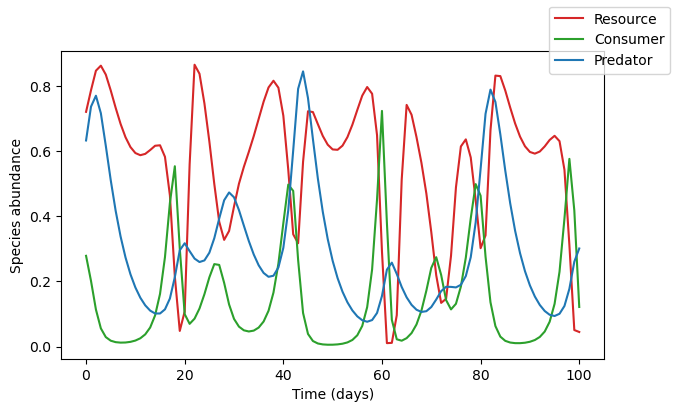

(<py Figure size 700x400 with 1 Axes>, <py Axes: xlabel='Time (days)', ylabel='Species abundance'>)

In [13]:
fig, ax = plot_time_series(simulate(model))

### Generating our synthetic dataset

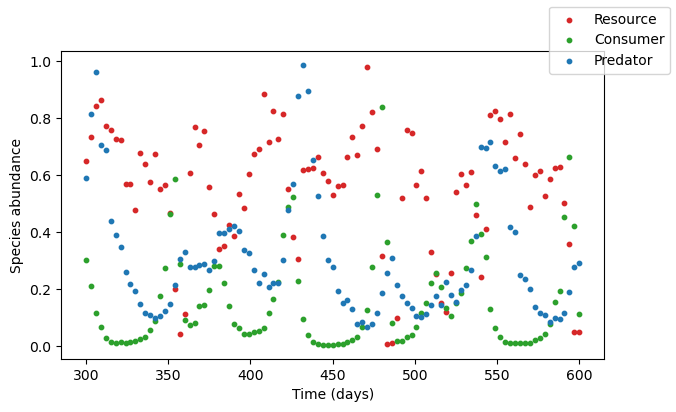

In [14]:
data = simulate(model) |> Array

# contaminating raw data with noise
data = data .* exp.(1f-1*randn(Float32, size(data)))

# plotting
fig, ax = subplots(figsize=(7,4))

for i in 1:size(data,1)
    ax.scatter(tsteps, data[i, :], label=labels_sp[i], color = species_colors[i], s=10.)
end
# ax.set_yscale("log")
ax.set_ylabel("Species abundance")
ax.set_xlabel("Time (days)")
fig.set_facecolor("None")
ax.set_facecolor("None")
fig.legend()
display(fig)


## Empirical modelling

Let's build a ML-model, and train the model on the time series.

We'll use a recurrent neural network model

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/1280px-Recurrent_neural_network_unfold.svg.png)


In [15]:
include("rnn.jl") # Load some utility functions


simulate (generic function with 2 methods)

In [16]:
using Flux
args = ArgsEco() # Set up hyperparameters

rbf(x) = exp.(-(x.^2)) # custom activation function

hls = 64 # hidden layer size

# Definition of the RNN
# our model takes in the ecosystem state variables, together with current water availability
rnn_model = Flux.Chain(LSTM(N + 1, hls),
            Flux.Dense(hls, hls, relu),
                Flux.Dense(hls, N, rbf))

@time train_model!(rnn_model, data, args)   # Train and output model

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = LSTMCell(4 => 64)
│   summary(x) = "4×51 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/Nzh8J/src/layers/stateless.jl:50
[ Info: Epoch 100 / 1000, train loss: 527.952
[ Info: Epoch 200 / 1000, train loss: 204.361
[ Info: Epoch 300 / 1000, train loss: 162.066
[ Info: Epoch 400 / 1000, train loss: 120.162
[ Info: Epoch 500 / 1000, train loss: 90.874
[ Info: Epoch 600 / 1000, train loss: 75.814
[ Info: Epoch 700 / 1000, train loss: 60.059
[ Info: Epoch 800 / 1000, train loss: 52.364
[ Info: Epoch 900 / 1000, train loss: 49.887


 43.376011 seconds (124.37 M allocations: 48.161 GiB, 7.24% gc time, 50.98% compilation time)


[ Info: Epoch 1000 / 1000, train loss: 41.365


In [17]:
tsteps_forecast = tspan[end]+dt:dt:tspan[end]+100*dt

water_availability_range = water_availability.(vcat(tsteps, tsteps_forecast))
init_states = data[:,1:2]

pred_rnn = simulate(rnn_model, init_states, water_availability_range)


3×200 Matrix{Float32}:
 0.762395  0.797165   0.793289   0.766916   …  0.693398  0.657257  0.471914
 0.10789   0.0664972  0.0401597  0.0270996     0.330668  0.449284  0.445339
 0.576633  0.572054   0.515117   0.44136       0.272169  0.348038  0.489159

And let's plot it

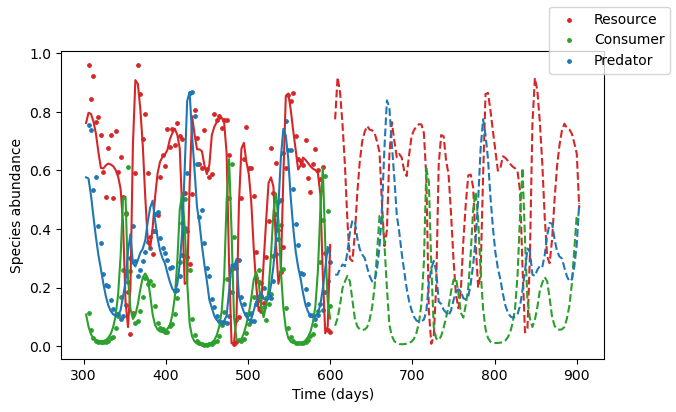

In [18]:


fig, ax = subplots(1, figsize=(7,4))
for i in 1:N
    ax.scatter(tsteps[3:end], 
                data[i, 3:end], 
                label = labels_sp[i], 
                color = species_colors[i],
                s = 6.)
    ax.plot(tsteps[2:end], 
            pred_rnn[i,1:length(tsteps)-1], 
            c = species_colors[i])
    ax.plot(tsteps_forecast .+ dt, 
            pred_rnn[i,length(tsteps):end], 
            linestyle="--", 
            c = species_colors[i])
end
ax.set_ylabel("Species abundance")
ax.set_xlabel("Time (days)")
fig.set_facecolor("None")
ax.set_facecolor("None")
fig.legend()
display(fig)

Looks pretty good!

Now let's see what happens if we remove the resource

In [19]:
water_availability_range = water_availability.(tsteps)
init_states = data[:,1:2]
init_states[1,:] .= 0.
pred_rnn = simulate(rnn_model, init_states, water_availability_range)

3×100 Matrix{Float32}:
 0.676712   0.865029   0.859097   …  0.0436013  0.0717751  0.366179
 0.0758339  0.0441694  0.0240835     0.340676   0.149523   0.0942007
 0.576114   0.562813   0.492374      0.269714   0.342344   0.304846

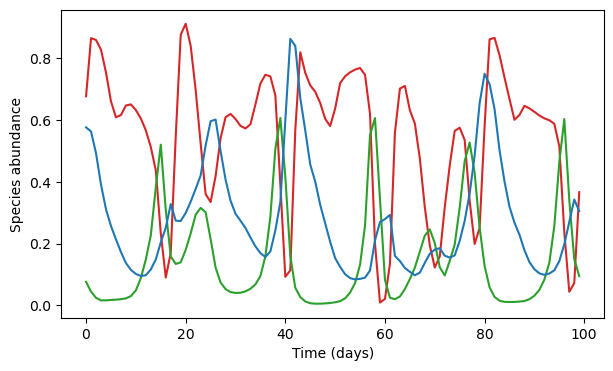

In [20]:
fig, ax = subplots(1, figsize=(7,4))
for i in 1:N
    ax.plot( 
            pred_rnn[i,:], 
            c = species_colors[i])
end
ax.set_ylabel("Species abundance")
ax.set_xlabel("Time (days)")
fig.set_facecolor("None")
ax.set_facecolor("None")
display(fig)

There is clearly a problem!

In summary, ML-based model

- 👍 Very good for interpolation
- 👍 Does not require any knowledge from the system, only data!
- 👎 Cannot extrapolate

## Mechanistic modelling


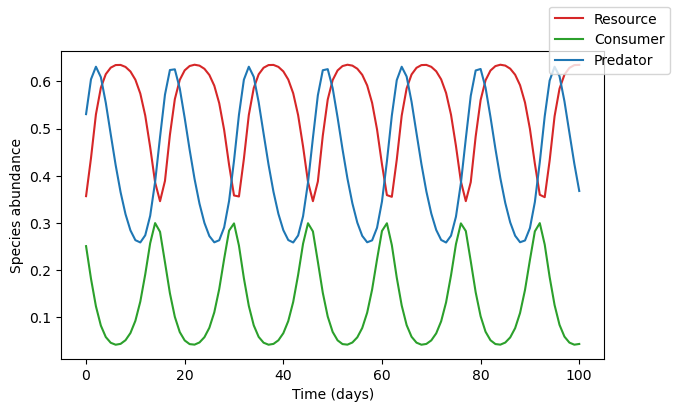

In [21]:
p_mech = ComponentArray(H₂₁=Float32[1.1],
                        H₃₂=Float32[2.3],
                        q₂₁=Float32[4.98],
                        q₃₂=Float32[0.8],
                        r = Float32[1.0, -0.4, -0.08],
                        K₁₁=Float32[0.8],
                        A₁₁=Float32[1.2])

u0_mech = Float32[0.77, 0.060, 0.945]

mp = ModelParams(; p=p_mech,
                u0=u0_mech,
                solve_params...)

growth_rate_mech(p, t) = p.r

model_mechanistic = SimpleEcosystemModel(; mp, intinsic_growth_rate = growth_rate_mech ,
                                        carrying_capacity,
                                        competition,
                                        resource_conversion_efficiency,
                                        feeding)

simul_data = simulate(model_mechanistic)

plot_time_series(simul_data);

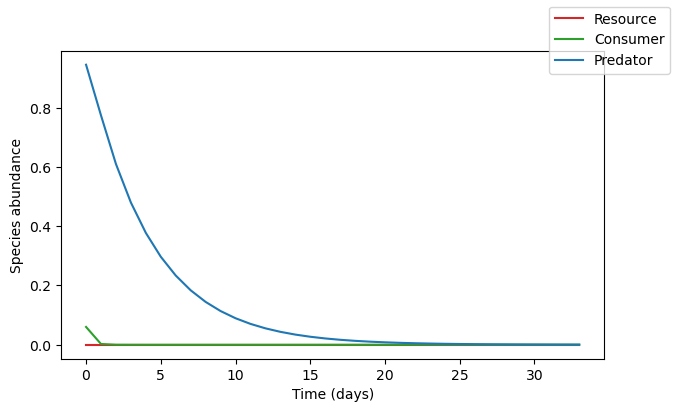

In [22]:
simul_data = simulate(model_mechanistic, 
                u0 = Float32[0., 0.060, 0.945], 
                saveat=0:dt:100.)

plot_time_series(simul_data);

That makes much more sense!!!

In summary, mechanistic models

- 👍 Very good for extrapolating to novel scenarios
- 👎 Hard to parametrise
- 👎 Inacurate

How can we relate the mechanistic model to the empirical system 🤔

## Inverse modelling

**Use the observed data to infer the parameters of a model**

- **Bayesian inference**
  - provide **uncertainties estimations**
  - does not scale well with the number of parameters to explore

- **Variational optimization**
  - Does not suffer from the curse of dimensionality
  - Convergence to local minima 
  - Need for parameter sensitivity


$$
\text{L} = \sum_i [\text{observations} - \text{simulations}]^2
$$

Minimize $\text{L}$ with gradient descent

![](https://upload.wikimedia.org/wikipedia/commons/a/a3/Gradient_descent.gif?20190425084312)

This works very well! In theory.

In practice

![](img/2d_landscape_rugged.png)

### PiecewiseInference.jl

> ~~Boussange, V., Vilimelis-Aceituno, P., Pellissier, L., Mini-batching ecological data to improve ecosystem models with machine learning. [bioRxiv] (2022), 46 pages.~~

> Boussange, V., Vilimelis-Aceituno, P., Pellissier, L., Partioning ecological time series to improve ecosystem models with machine learning.




![](img/loss2.png)

![](img/land_derugged.png)


In [23]:
include("utils.jl");


In [24]:
using PiecewiseInference

loss_likelihood(data, pred, rg) = sum((log.(data) .- log.(pred)).^2)

infprob = InferenceProblem(model_mechanistic, 
                            p_mech; 
                            loss_likelihood, 
                            inference_problem_args...);
info_per_its = 50

@time res_mech = piecewise_MLE(infprob;
                        group_size = 11,
                        data = data,
                        tsteps = tsteps,
                        optimizers = [Adam(1e-2)],
                        epochs = [500],
                        piecewise_MLE_args...)

[ Info: Precompiling PiecewiseInference [27a201f4-b6a1-4745-b96e-0c27845dca54]
[ Info: Skipping precompilation since __precompile__(false). Importing PiecewiseInference [27a201f4-b6a1-4745-b96e-0c27845dca54].


piecewise_MLE with 101 points and 10 groups.


[ Info: Training started
[ Info: Running optimizer Adam


Current loss after 50 iterations: 15.201576232910156
Current loss after 100 iterations: 11.719864845275879
Current loss after 150 iterations: 10.821453094482422
Current loss after 200 iterations: 10.495152473449707
Current loss after 250 iterations: 10.385421752929688
Current loss after 300 iterations: 10.342930793762207
Current loss after 350 iterations: 10.320155143737793
Current loss after 400 iterations: 10.305157661437988
Current loss after 450 iterations: 10.295003890991211
Current loss after 500 iterations: 10.28812313079834
162.898745 seconds (1.16 G allocations: 174.131 GiB, 9.35% gc time, 26.05% compilation time: 0% of which was recompilation)


[ Info: Minimum loss for all batches: 10.288121223449707


`InferenceResult` with model SimpleEcosystemModel


![](https://github.com/vboussange/PiecewiseInference.jl/raw/main/docs/animated.gif)

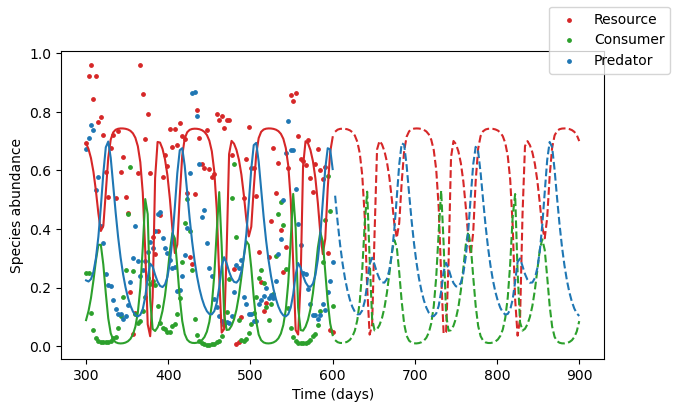

In [25]:
simul_mech_forecast = simulate(model_mechanistic, 
                                p = res_mech.p_trained, 
                                u0 = data[:,1],
                                saveat = vcat(tsteps, tsteps_forecast), 
                                tspan = (0, tsteps_forecast[end]));

fig, ax = subplots(1, figsize=(7,4))
for i in 1:N
    ax.scatter(tsteps, 
                data[i,:], 
                label = labels_sp[i], 
                color = species_colors[i],
                s = 6.)
    ax.plot(tsteps[1:end], 
            simul_mech_forecast[i,1:length(tsteps)], 
            c = species_colors[i])
    ax.plot(tsteps_forecast, 
            simul_mech_forecast[i,length(tsteps)+1:end], 
            linestyle="--", 
            c = species_colors[i])
end
ax.set_ylabel("Species abundance")
ax.set_xlabel("Time (days)")
fig.set_facecolor("None")
ax.set_facecolor("None")
fig.legend()
display(fig)

### Now we can study more interesting scenarios!



What happens if preys become extinct?

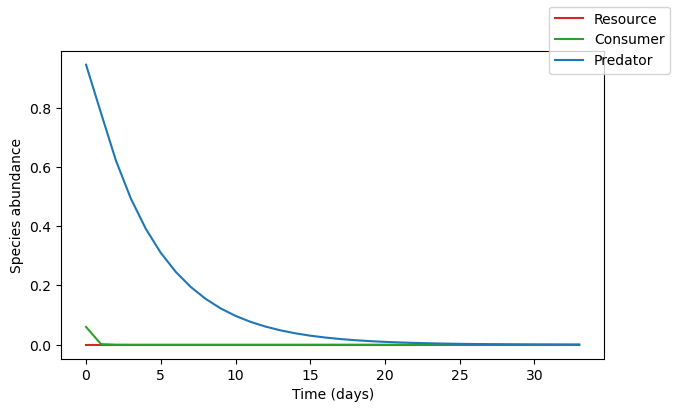

In [26]:
plot_time_series(simulate(model_mechanistic, 
                p = res_mech.p_trained, 
                u0 = Float32[0., 0.060, 0.945], 
                saveat=0:dt:100.));

In summary, mechanistic models

- 👍 Very good for extrapolating to novel scenarios
- 👎 ~~Hard to parametrise~~
- 👎 Inacurate

## Hybrid models

### 🤖 + 🔬= 🤯

In [27]:
using Lux
rng = Random.default_rng()
# Multilayer FeedForward
hlsize = 5
neural_net = Lux.Chain(Lux.Dense(1,hlsize,rbf), 
                        Lux.Dense(hlsize,hlsize, rbf), 
                        Lux.Dense(hlsize,hlsize, rbf), 
                        Lux.Dense(hlsize, 1))
# Get the initial parameters and state variables of the model
p_nn, st = Lux.setup(rng, neural_net)
p_nn = p_nn |> ComponentArray

growth_rate_resource_nn(p_nn, water) = neural_net([water], p_nn, st)[1]

function hybrid_growth_rate(p, t)
    return [growth_rate_resource_nn(p.p_nn, water_availability(t)); p.r]
end



hybrid_growth_rate (generic function with 1 method)

In [28]:
p_hybr = ComponentArray(H₂₁=p_mech.H₂₁,
                        H₃₂=p_mech.H₃₂,
                        q₂₁=p_mech.q₂₁,
                        q₃₂=p_mech.q₃₂,
                        r = p_mech.r[2:3],
                        K₁₁=p_mech.K₁₁,
                        A₁₁=p_mech.A₁₁,
                        p_nn = p_nn)

mp = ModelParams(;p=p_hybr,
                u0=u0_mech,
                solve_params...)

model_hybrid = SimpleEcosystemModel(; mp, 
                                    intinsic_growth_rate = hybrid_growth_rate,
                                    carrying_capacity,
                                    competition,
                                    resource_conversion_efficiency,
                                    feeding)

`Model` SimpleEcosystemModel


In [29]:
infprob = InferenceProblem(model_hybrid, 
                            p_hybr; 
                            loss_likelihood, 
                            inference_problem_args...);

res_hybr = piecewise_MLE(infprob;
                    group_size = 11,
                    data = data,
                    tsteps = tsteps,
                    optimizers = [Adam(2e-2)],
                    epochs = [500],
                    piecewise_MLE_args...)

piecewise_MLE with 101 points and 10 groups.


[ Info: Training started
[ Info: Running optimizer Adam


Current loss after 50 iterations: 37.37157440185547
Current loss after 100 iterations: 12.8524751663208
Current loss after 150 iterations: 9.646836280822754
Current loss after 200 iterations: 8.07744026184082
Current loss after 250 iterations: 6.73315954208374
Current loss after 300 iterations: 5.541690349578857
Current loss after 350 iterations: 4.6014533042907715
Current loss after 400 iterations: 3.979525327682495
Current loss after 450 iterations: 3.63020920753479
Current loss after 500 iterations: 3.452625274658203


[ Info: Minimum loss for all batches: 3.452625274658203


`InferenceResult` with model SimpleEcosystemModel


In [30]:
simul_hybr_forecast = simulate(model_hybrid, 
                                p = res_hybr.p_trained, 
#                                 u0 = res_hybr.u0s_trained[1],
                                u0 = data[:,1],
                                saveat = vcat(tsteps, tsteps_forecast), 
                                tspan = (0, tsteps_forecast[end]));

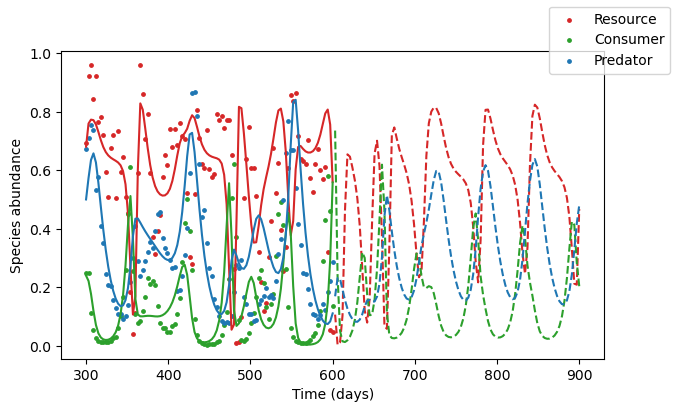

In [31]:
fig, ax = subplots(1, figsize=(7,4))
for i in 1:N
    ax.scatter(tsteps, 
                data[i,:], 
                label = labels_sp[i], 
                color = species_colors[i],
                s = 6.)
    ax.plot(tsteps[1:end], 
        simul_hybr_forecast[i,1:length(tsteps)], 
            c = species_colors[i])
    ax.plot(tsteps_forecast, 
            simul_hybr_forecast[i,length(tsteps)+1:end], 
            linestyle="--", 
            c = species_colors[i])
end
ax.set_ylabel("Species abundance")
ax.set_xlabel("Time (days)")
fig.set_facecolor("None")
ax.set_facecolor("None")
fig.legend()
display(fig)

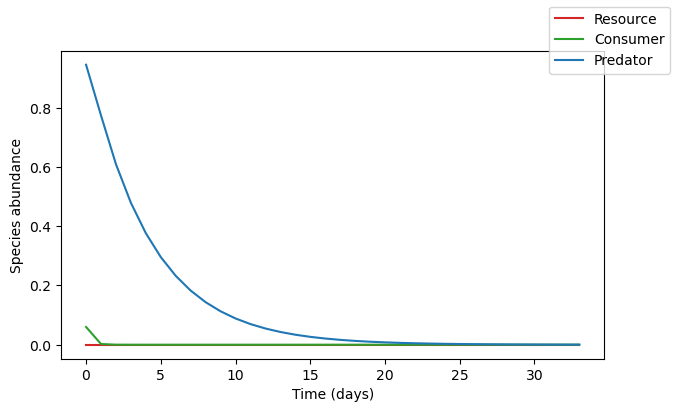

In [32]:
plot_time_series(simulate(model_hybrid, 
                p = res_hybr.p_trained, 
                u0 = Float32[0., 0.060, 0.945], 
                saveat=0:dt:100.));

### Improve our understanding of living systems

Once the neural network has been trained, we can interpret it!


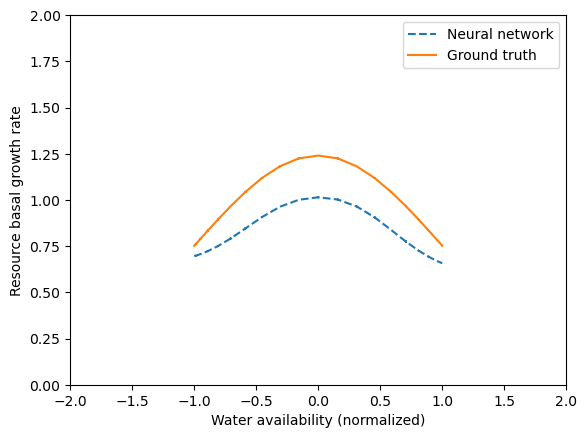

In [33]:
water_avail = reshape(sort!(water_availability.(tsteps)),1,:)

p_nn_trained = res_hybr.p_trained.p_nn
gr = neural_net(water_avail, p_nn_trained, st)[1]


fig, ax = subplots(1)
ax.plot(water_avail[:], 
        gr[:], 
        label="Neural network",
        linestyle="--")

gr_true = model.mp.p[1] .* exp.(-0.5 .* water_avail.^2)
ax.plot(water_avail[:], gr_true[:], label="Ground truth")
ax.set_ylim(0,2)
ax.set_xlim(-2,2)
ax.legend()
xlabel("Water availability (normalized)")
ylabel("Resource basal growth rate")
display(fig)


## Wrap-up

### Hybrid approaches are the future!

> Les données pertinentes détiennent les réponses

> A model is worth 1000 datasets!


![](img/gentine.png)

- Require 
  - domain **specific knowledge**
  - expertise in **mechanistic modelling**
    - 👍 [EcoEvoModelZoo.jl](https://github.com/vboussange/EcoEvoModelZoo.jl)
  - expertise in **machine learning**
    - 👍 [Flux.jl model zoo](https://github.com/FluxML/model-zoo)
- Requires **differentiable programming** and **interoperability** between scientific libraries
  - What <img src="https://docs.julialang.org/en/v1/assets/logo.svg" width="100"/>
 is best at

  - But JAX is also very cool 🫠


# Thanks for your attention!